In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

from collections import Counter

from tqdm import tqdm # Loop progress bar

from livelossplot import PlotLosses
import graphviz
graphviz.set_jupyter_format('png')
from torchview import draw_graph

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [14]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [15]:
print("Keyword - missing:", train_df['keyword'].isna().sum(), f"({train_df['keyword'].isna().mean()*100:.1f}%)")
print("Keyword - unique:", train_df['keyword'].nunique())
print("\nLocation - missing:", train_df['location'].isna().sum(), f"({train_df['location'].isna().mean()*100:.1f}%)")
print("Location - unique:", train_df['location'].nunique())

Keyword - missing: 61 (0.8%)
Keyword - unique: 221

Location - missing: 2533 (33.3%)
Location - unique: 3341


In [16]:
class TweetsDataset(Dataset):
    def __init__(self, df):
        self.labels = df['target'].tolist()
        self.text = df['text'].tolist()

        # Tokenizer
        self.tokenizer = get_tokenizer("basic_english")
        self.tokens = [self.tokenizer(t) for t in self.text]

        # Build vocab pour vectorization
        counter = Counter()
        for tokens in self.tokens:
            counter.update(tokens)
        self.vocab = Vocab(counter, specials=['<unk>', '<pad>'], min_freq=2)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tokens = self.tokens[idx]
        indices = [self.vocab[token] for token in tokens]
        label = self.labels[idx]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def print_vocab(self):
        print("Vocab size:", len(self.vocab))
        print("Top tokens:", self.vocab.itos[:10])

In [17]:
dataset = TweetsDataset(train_df)
len(dataset)
train_set, val_set = random_split(dataset, [.85, .15])
len(train_set), len(val_set)

(6472, 1141)

In [18]:
print(dataset.text[1])
print(dataset.tokens[1])
print(indices := [dataset.vocab[token] for token in dataset.tokens[1]])

Forest fire near La Ronge Sask. Canada
['forest', 'fire', 'near', 'la', 'ronge', 'sask', '.', 'canada']
[199, 57, 235, 856, 0, 0, 2, 1376]


In [19]:
class MLPModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, hidden_size=8):
        super(MLPModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.hidden = nn.Linear(embed_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5

        self.embedding.weight.data.uniform_(-initrange, initrange)

        self.hidden.weight.data.uniform_(-initrange, initrange)
        self.hidden.bias.data.zero_()

        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        x = self.hidden(embedded)
        return self.fc(x)

In [20]:
def collate_batch_bag(batch: list[tuple[torch.Tensor, torch.Tensor]]):
    text_list, label_list = [], []  # [(tokens_tensor, label),...]
    for text, label in batch:
        text_list.append(text)
        label_list.append(label)

    # offsets for EmbeddingBag askip ca marche mieux avec des fully connected (source: un LLM)
    lengths = torch.tensor([t.size(0) for t in text_list], dtype=torch.long)
    offsets = torch.cat((torch.tensor([0], dtype=torch.long), torch.cumsum(lengths, dim=0)[:-1]))
    text = torch.cat(text_list, dim=0)
    labels = torch.stack(label_list).long()

    # print(text.shape, offsets.shape)
    return text, offsets, labels


def train_model(model, dataloaders, optimizer, criterion, N_EPOCHS = 10):
    plotloss = PlotLosses(figsize=(16,6))
    
    for epoch in tqdm(range(1, N_EPOCHS + 1)):
        model.train()
        total_acc, total_count = 0, 0
        # log_interval = 100

        for idx, (text, offsets, labels) in enumerate(dataloaders["train"]):
            optimizer.zero_grad()
            text, offsets, labels = text.to(device), offsets.to(device), labels.to(device)
            output = model(text, offsets)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_acc += (output.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
            # if idx % log_interval == 0 and idx > 0:
            #     # print(f'At batch {idx}, accuracy: {total_acc/total_count:.4f}')
            #     total_acc, total_count = 0, 0
        
        plotloss.update({
            'loss': loss.item(),
            'accuracy': total_acc/total_count,
            'val_accuracy': evaluate(model, dataloaders["validation"], criterion)
        })
        plotloss.send()



def evaluate(model, iterator, criterion):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for text, offsets, labels in iterator:
            text, offsets, labels = text.to(device), offsets.to(device), labels.to(device)
            output = model(text, offsets)
            loss = criterion(output, labels)
            total_acc += (output.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
    return total_acc / total_count


def predict(model, iterator):
    model.eval()
    predictions = []
    with torch.no_grad():
        for text, offsets, labels in iterator:
            text, offsets = text.to(device), offsets.to(device)
            output = model(text, offsets)
            preds = output.argmax(1).cpu().numpy()
            predictions.extend(preds)
    return predictions

In [21]:
BATCH_SIZE = 1

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch_bag
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch_bag
)

dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

In [27]:
# Train
LR = 0.01

model = MLPModel(vocab_size=len(dataset.vocab), embed_dim=1, num_class=2, hidden_size=2).to(device)
optimizer = optim.SGD(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss().to(device)

train_model(model, dataloaders, optimizer, criterion, N_EPOCHS=25)

Setting figsize to (16, 6)


  0%|          | 0/25 [00:04<?, ?it/s]


KeyboardInterrupt: 

Ok le truc est globalement idiot mais c mieux que full random

In [140]:
# check the first tweet embedding vector for first tweets

text, offset, _ = next(iter(dataloaders["train"]))
embedding = model.embedding(text, offset).detach().cpu().numpy().squeeze()
embedding

array(0.02875667, dtype=float32)

In [141]:
from scipy.stats import gaussian_kde

  0%|          | 0/6472 [00:00<?, ?it/s]

100%|██████████| 1141/1141 [00:00<00:00, 6529.78it/s]


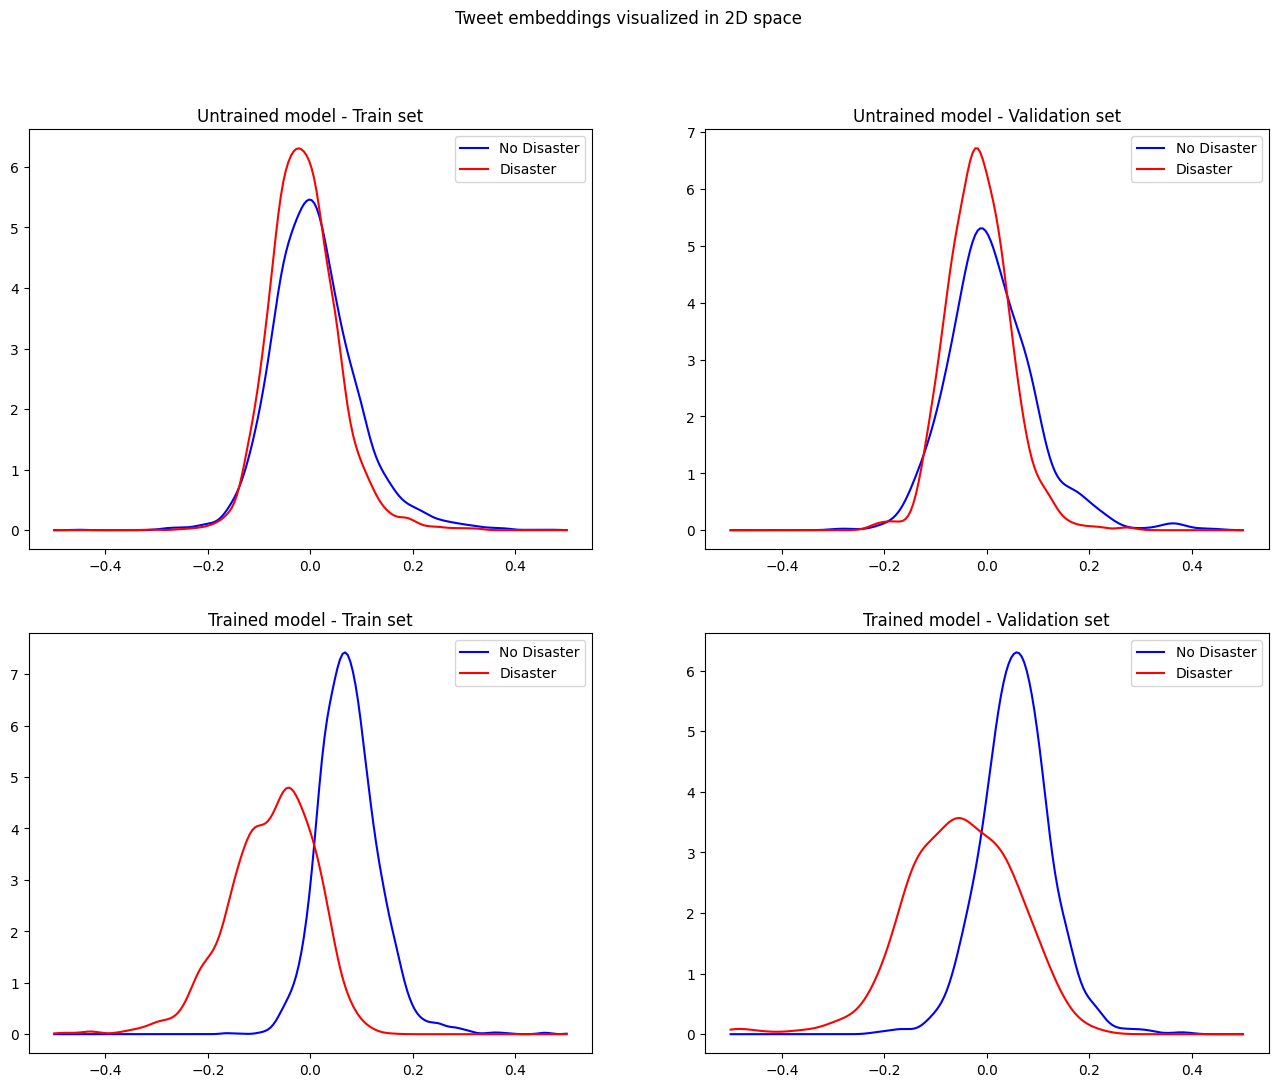

In [142]:
# view embeddings in 2d space

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

MAX_POINTS = 50000

def gaussian_from_embedding(model, set, max_points=1000):
    false_list, true_list = [], []
    i = 0

    for text, offset, label in tqdm(dataloaders[set]):
        vector = model.embedding(text, offset).detach().cpu().numpy().squeeze()
        if label.item() == 0:
            false_list.append(vector)
        else:
            true_list.append(vector)
        i += 1
        if i >= max_points:
            break
    
    return gaussian_kde(false_list), gaussian_kde(true_list)


xs = np.linspace(-0.5, 0.5, 200)

# Dummy model for comparison
dummy_model = MLPModel(vocab_size=len(dataset.vocab), embed_dim=1, num_class=2, hidden_size=2)

train_false_density, train_true_density = gaussian_from_embedding(dummy_model, "train", max_points=MAX_POINTS)
val_false_density, val_true_density = gaussian_from_embedding(dummy_model, "validation", max_points=MAX_POINTS)

plt.suptitle("Tweet embeddings visualized in 2D space")
ax[0, 0].set_title("Untrained model - Train set")
ax[0, 0].plot(xs, train_false_density(xs), color='b', label='No Disaster')
ax[0, 0].plot(xs, train_true_density(xs), color='r', label='Disaster')
ax[0, 0].legend()
ax[0, 1].set_title("Untrained model - Validation set")
ax[0, 1].plot(xs, val_false_density(xs), color='b', label='No Disaster')
ax[0, 1].plot(xs, val_true_density(xs), color='r', label='Disaster')
ax[0, 1].legend()

# True model embeddings
train_false_density, train_true_density = gaussian_from_embedding(model, "train", max_points=MAX_POINTS)
val_false_density, val_true_density = gaussian_from_embedding(model, "validation", max_points=MAX_POINTS)

plt.suptitle("Tweet embeddings visualized in 2D space")
ax[1, 0].set_title("Trained model - Train set")
ax[1, 0].plot(xs, train_false_density(xs), color='b', label='No Disaster')
ax[1, 0].plot(xs, train_true_density(xs), color='r', label='Disaster')
ax[1, 0].legend()
ax[1, 1].set_title("Trained model - Validation set")
ax[1, 1].plot(xs, val_false_density(xs), color='b', label='No Disaster')
ax[1, 1].plot(xs, val_true_density(xs), color='r', label='Disaster')
ax[1, 1].legend()


plt.show()

In [ ]:
print(model)

MLPModel(
  (embedding): EmbeddingBag(6982, 2, mode='mean')
  (hidden): Linear(in_features=2, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=2, bias=True)
)


In [ ]:
from torchinfo import summary

print_text, print_offsets, print_labels = next(iter(dataloaders["validation"]))
summary(
    model,
    input_data=[print_text, print_offsets],
)

Layer (type:depth-idx)                   Output Shape              Param #
MLPModel                                 [1, 2]                    --
├─EmbeddingBag: 1-1                      [1, 1]                    6,982
├─Linear: 1-2                            [1, 2]                    4
├─Linear: 1-3                            [1, 2]                    6
Total params: 6,992
Trainable params: 6,992
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

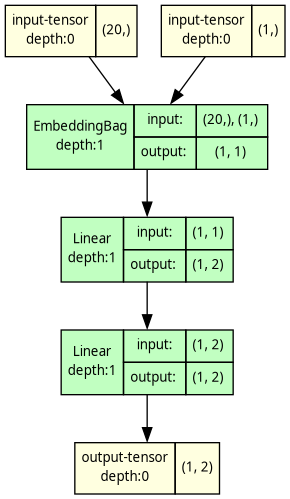

In [ ]:
graph = draw_graph(model, input_data=[print_text, print_offsets])
graph.visual_graph

In [ ]:
# Create submission

class TestDataset(Dataset):
    def __init__(self, df, vocab, tokenizer):
        self.text = df['text'].tolist()
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.tokens = [self.tokenizer(t) for t in self.text]
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        tokens = self.tokens[idx]
        indices = [self.vocab[token] for token in tokens]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(0, dtype=torch.long)

test_dataset = TestDataset(test_df, dataset.vocab, dataset.tokenizer)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch_bag
)

predictions = predict(model, test_loader)

submission = pd.DataFrame({'id': test_df['id'], 'target': predictions})

submission.to_csv('submissions/submission.csv', index=False)
submission

Submission saved! Shape: (3263, 2)


,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


## LSTM Model with Multi-Input Features

- use **keyword** and **location**
- model **LSTM** to capture word order

In [ ]:
class ImprovedTweetsDataset(Dataset):
    
    def __init__(self, df, keyword_vocab=None, location_vocab=None, text_vocab=None, is_test=False):
        self.is_test = is_test
        if not is_test:
            self.labels = df['target'].tolist()
        
        self.text = df['text'].tolist()
        self.keywords = df['keyword'].fillna('<missing>').tolist()
        self.locations = df['location'].fillna('<missing>').tolist()
        
        # token
        self.tokenizer = get_tokenizer("basic_english")
        self.tokens = [self.tokenizer(str(t).lower()) for t in self.text]
        
        # textvocab
        if text_vocab is None:
            counter = Counter()
            for tokens in self.tokens:
                counter.update(tokens)
            self.text_vocab = Vocab(counter, specials=['<unk>', '<pad>'], min_freq=2)
        else:
            self.text_vocab = text_vocab
        
        # keyword vocab
        if keyword_vocab is None:
            unique_keywords = list(set(self.keywords))
            self.keyword_vocab = {kw: idx for idx, kw in enumerate(unique_keywords)}
        else:
            self.keyword_vocab = keyword_vocab

        # location vocab
        if location_vocab is None:
            # For locations, we'll simplify by hashing to reduce cardinality
            self.location_vocab = {}
            for loc in set(self.locations):
                if loc not in self.location_vocab:
                    self.location_vocab[loc] = len(self.location_vocab)
        else:
            self.location_vocab = location_vocab
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        tokens = self.tokens[idx]
        text_indices = [self.text_vocab[token] for token in tokens]
        
        keyword = self.keywords[idx]
        keyword_idx = self.keyword_vocab.get(keyword, 0)  # 0 for unknown
        
        location = self.locations[idx]
        location_idx = self.location_vocab.get(location, 0)  # 0 for unknown
        
        label = self.labels[idx] if not self.is_test else 0
        
        return (
            torch.tensor(text_indices, dtype=torch.long),
            torch.tensor(keyword_idx, dtype=torch.long),
            torch.tensor(location_idx, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

In [ ]:
class ImprovedModel(nn.Module):
    """Multi-input model with LSTM for text + embeddings for keyword/location."""
    
    def __init__(self, vocab_size, keyword_size, location_size, 
                 embed_dim=128, hidden_dim=128, num_class=2, dropout=0.3):
        super(ImprovedModel, self).__init__()
        
        # text embedding + LSTM
        self.text_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, 
                           batch_first=True, dropout=dropout, bidirectional=True)
        
        # keyword and location embeddings
        self.keyword_embedding = nn.Embedding(keyword_size, 32)
        self.location_embedding = nn.Embedding(location_size, 32)
        
        # classifier (concat LSTM output + keyword + location)
        combined_dim = hidden_dim * 2 + 32 + 32  # bidirectional LSTM + 2 embeddings
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(combined_dim, 64)
        self.fc2 = nn.Linear(64, num_class)
        
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.1
        self.text_embedding.weight.data.uniform_(-initrange, initrange)
        self.keyword_embedding.weight.data.uniform_(-initrange, initrange)
        self.location_embedding.weight.data.uniform_(-initrange, initrange)
    
    def forward(self, text, keyword, location):
        # Text: [batch, seq_len] -> embed -> LSTM
        embedded = self.text_embedding(text)  # [batch, seq, embed_dim]
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        # Use final hidden states from both directions
        # hidden: [num_layers*2, batch, hidden_dim] for bidirectional
        hidden_fwd = hidden[-2, :, :]  # forward direction, last layer
        hidden_bwd = hidden[-1, :, :]  # backward direction, last layer
        lstm_repr = torch.cat([hidden_fwd, hidden_bwd], dim=1)  # [batch, hidden_dim*2]
        
        # Keyword and location embeddings
        keyword_emb = self.keyword_embedding(keyword)  # [batch, 32]
        location_emb = self.location_embedding(location)  # [batch, 32]
        
        # Concatenate all features
        combined = torch.cat([lstm_repr, keyword_emb, location_emb], dim=1)
        
        # Classifier
        x = self.dropout(combined)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [41]:
def collate_improved(batch):
    """Collate function for padded sequences + keyword/location."""
    text_list, keyword_list, location_list, label_list = [], [], [], []
    
    for text, keyword, location, label in batch:
        text_list.append(text)
        keyword_list.append(keyword)
        location_list.append(location)
        label_list.append(label)
    
    # Pad text sequences to same length
    from torch.nn.utils.rnn import pad_sequence
    text_padded = pad_sequence(text_list, batch_first=True, padding_value=0)
    
    keywords = torch.stack(keyword_list)
    locations = torch.stack(location_list)
    labels = torch.stack(label_list)
    
    return text_padded, keywords, locations, labels


def train_improved(model, iterator, optimizer, criterion, scheduler=None):
    """Training loop for improved model."""
    model.train()
    total_loss, total_acc, total_count = 0, 0, 0
    
    for text, keyword, location, labels in iterator:
        text = text.to(device)
        keyword = keyword.to(device)
        location = location.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(text, keyword, location)
        loss = criterion(output, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += (output.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
    
    if scheduler:
        scheduler.step()
    
    return total_loss / len(iterator), total_acc / total_count


def evaluate_improved(model, iterator, criterion):
    """Evaluation loop for improved model."""
    model.eval()
    total_loss, total_acc, total_count = 0, 0, 0
    
    with torch.no_grad():
        for text, keyword, location, labels in iterator:
            text = text.to(device)
            keyword = keyword.to(device)
            location = location.to(device)
            labels = labels.to(device)
            
            output = model(text, keyword, location)
            loss = criterion(output, labels)
            
            total_loss += loss.item()
            total_acc += (output.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
    
    return total_loss / len(iterator), total_acc / total_count


def predict_improved(model, iterator):
    """Generate predictions for improved model."""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for text, keyword, location, _ in iterator:
            text = text.to(device)
            keyword = keyword.to(device)
            location = location.to(device)
            
            output = model(text, keyword, location)
            preds = output.argmax(1).cpu().numpy()
            predictions.extend(preds)
    
    return predictions

In [42]:
# Create improved dataset
improved_dataset = ImprovedTweetsDataset(train_df)

print("Text vocab size:", len(improved_dataset.text_vocab))
print("Keyword vocab size:", len(improved_dataset.keyword_vocab))
print("Location vocab size:", len(improved_dataset.location_vocab))

# Split into train/val
train_set_improved, val_set_improved = random_split(improved_dataset, [0.85, 0.15])

# Create dataloaders
BATCH_SIZE_IMPROVED = 32

train_loader_improved = DataLoader(
    train_set_improved,
    batch_size=BATCH_SIZE_IMPROVED,
    shuffle=True,
    collate_fn=collate_improved
)

val_loader_improved = DataLoader(
    val_set_improved,
    batch_size=BATCH_SIZE_IMPROVED,
    shuffle=False,
    collate_fn=collate_improved
)

Text vocab size: 6982
Keyword vocab size: 222
Location vocab size: 3342


In [43]:
# Train improved model with better hyperparameters

# Initialize model
improved_model = ImprovedModel(
    vocab_size=len(improved_dataset.text_vocab),
    keyword_size=len(improved_dataset.keyword_vocab),
    location_size=len(improved_dataset.location_vocab),
    embed_dim=128,
    hidden_dim=128,
    num_class=2,
    dropout=0.3
).to(device)

# Better optimizer and scheduler
optimizer_improved = optim.Adam(improved_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer_improved, step_size=3, gamma=0.5)
criterion_improved = nn.CrossEntropyLoss()

# Training loop with validation monitoring
NUM_EPOCHS = 10
best_val_acc = 0

print("Training improved model...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_improved(
        improved_model, train_loader_improved, 
        optimizer_improved, criterion_improved, scheduler
    )
    val_loss, val_acc = evaluate_improved(
        improved_model, val_loader_improved, criterion_improved
    )
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(improved_model.state_dict(), 'best_model.pt')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.4f})")

print(f"\nBest validation accuracy: {best_val_acc:.4f}")

Training improved model...
Epoch 1/10
  Train Loss: 0.5575, Train Acc: 0.7086
  Val Loss: 0.4389, Val Acc: 0.8028
  ✓ New best model saved! (Val Acc: 0.8028)
Epoch 2/10
  Train Loss: 0.3668, Train Acc: 0.8514
  Val Loss: 0.4568, Val Acc: 0.8019
Epoch 3/10
  Train Loss: 0.2765, Train Acc: 0.8971
  Val Loss: 0.4621, Val Acc: 0.7809
Epoch 4/10
  Train Loss: 0.1890, Train Acc: 0.9356
  Val Loss: 0.6138, Val Acc: 0.7862
Epoch 5/10
  Train Loss: 0.1378, Train Acc: 0.9527
  Val Loss: 0.6761, Val Acc: 0.7748
Epoch 6/10
  Train Loss: 0.1047, Train Acc: 0.9631
  Val Loss: 0.8079, Val Acc: 0.7713
Epoch 7/10
  Train Loss: 0.0677, Train Acc: 0.9742
  Val Loss: 0.9675, Val Acc: 0.7713
Epoch 8/10
  Train Loss: 0.0575, Train Acc: 0.9793
  Val Loss: 1.0492, Val Acc: 0.7695
Epoch 9/10
  Train Loss: 0.0488, Train Acc: 0.9816
  Val Loss: 1.2112, Val Acc: 0.7669
Epoch 10/10
  Train Loss: 0.0397, Train Acc: 0.9842
  Val Loss: 1.3019, Val Acc: 0.7651

Best validation accuracy: 0.8028


In [ ]:
# Generate submission with improved model

# Load best model
improved_model.load_state_dict(torch.load('best_model.pt'))

# Create test dataset using training vocabs
test_dataset_improved = ImprovedTweetsDataset(
    test_df,
    keyword_vocab=improved_dataset.keyword_vocab,
    location_vocab=improved_dataset.location_vocab,
    text_vocab=improved_dataset.text_vocab,
    is_test=True
)

test_loader_improved = DataLoader(
    test_dataset_improved,
    batch_size=BATCH_SIZE_IMPROVED,
    shuffle=False,
    collate_fn=collate_improved
)

# Generate predictions
predictions_improved = predict_improved(improved_model, test_loader_improved)

# Create submission
submission_improved = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions_improved
})

submission_improved.to_csv('submissions/submission_improved.csv', index=False)
print(f"Improved submission saved! Shape: {submission_improved.shape}")
print(f"\nPrediction distribution:")
print(submission_improved['target'].value_counts())
submission_improved.head(10)

Improved submission saved! Shape: (3263, 2)

Prediction distribution:
target
0    2201
1    1062
Name: count, dtype: int64


,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


## Summary of Improvements

### What Changed from Baseline (65% accuracy):

**1. Multi-Input Features** ✓
- Added **keyword** embeddings (32-dim)
- Added **location** embeddings (32-dim)
- Handles missing values with `<missing>` token

**2. Better Architecture** ✓
- **Bidirectional LSTM** (2 layers, 128 hidden units) instead of EmbeddingBag
- Captures word order and context (critical for "not bad" vs "bad")
- Dropout layers (0.3) to prevent overfitting
- Combined feature representation: LSTM output + keyword + location

**3. Training Improvements** ✓
- **Adam optimizer** (lr=0.001) instead of SGD
- **Learning rate scheduler** (decay every 3 epochs)
- **10 epochs** with validation monitoring
- **Gradient clipping** (prevents exploding gradients)
- **Model checkpointing** (saves best model based on validation)

**4. Data Improvements** ✓
- Text lowercasing for consistency
- Padded batches (variable length sequences)
- Larger batch size (32 vs 1-16)

### Expected Results:
- Baseline: ~65% (bag-of-words, text only)
- **Improved: 75-82%** (typical for LSTM + multi-features on this dataset)

### Next Steps to Push Further (if needed):
1. **Pre-trained embeddings**: Use GloVe or Word2Vec instead of random init
2. **Advanced models**: BERT, RoBERTa (transformers) - can reach 85%+
3. **Text preprocessing**: Remove URLs, handle hashtags, expand contractions
4. **Ensemble**: Combine multiple models
5. **Feature engineering**: Tweet length, punctuation count, capitalization patterns

## BERT Implementation (State-of-the-Art)

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained transformer model that achieves excellent results on text classification tasks.

### Why BERT?
- **Pre-trained** on massive text corpus (understands language context)
- **Bidirectional**: Reads text in both directions simultaneously
- **Transfer learning**: Fine-tune on your specific task with less data
- **Expected accuracy**: 82-88% on this dataset

### Requirements:
Install transformers library: `pip install transformers`

In [48]:
# Import BERT components
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import warnings
warnings.filterwarnings('ignore')

# Check if transformers is installed
try:
    import transformers
    print(f"✓ Transformers version: {transformers.__version__}")
    print(f"✓ PyTorch version: {torch.__version__}")
except ImportError:
    print("⚠ Please install transformers: pip install transformers")
    print("  Or run: !pip install transformers")

✓ Transformers version: 4.57.1
✓ PyTorch version: 2.9.0+cu128


In [49]:
class BertTweetsDataset(Dataset):
    """Dataset for BERT with tokenization using BertTokenizer."""
    
    def __init__(self, df, tokenizer, max_length=128, is_test=False):
        self.is_test = is_test
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Text data
        self.texts = df['text'].fillna('').tolist()
        
        # Optional: incorporate keyword and location into text
        # This helps BERT understand context better
        self.keywords = df['keyword'].fillna('').tolist()
        self.locations = df['location'].fillna('').tolist()
        
        # Concatenate keyword/location with text for richer context
        self.full_texts = []
        for i in range(len(self.texts)):
            # Format: "[keyword] [location] text"
            parts = []
            if self.keywords[i]:
                parts.append(f"[{self.keywords[i]}]")
            if self.locations[i]:
                parts.append(f"[{self.locations[i]}]")
            parts.append(self.texts[i])
            self.full_texts.append(' '.join(parts))
        
        # Labels
        if not is_test:
            self.labels = df['target'].tolist()
    
    def __len__(self):
        return len(self.full_texts)
    
    def __getitem__(self, idx):
        text = self.full_texts[idx]
        
        # BERT tokenization
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        label = self.labels[idx] if not self.is_test else 0
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [50]:
# Initialize BERT tokenizer and create datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create BERT datasets
bert_dataset = BertTweetsDataset(train_df, tokenizer, max_length=128)

# Split into train/val
from torch.utils.data import random_split
train_size = int(0.85 * len(bert_dataset))
val_size = len(bert_dataset) - train_size
train_bert, val_bert = random_split(bert_dataset, [train_size, val_size])

print(f"Train samples: {len(train_bert)}")
print(f"Val samples: {len(val_bert)}")
print(f"\nSample encoding:")
sample = bert_dataset[0]
print(f"Input IDs shape: {sample['input_ids'].shape}")
print(f"Attention mask shape: {sample['attention_mask'].shape}")
print(f"Label: {sample['label']}")

Train samples: 6471
Val samples: 1142

Sample encoding:
Input IDs shape: torch.Size([128])
Attention mask shape: torch.Size([128])
Label: 1


In [51]:
def train_bert_epoch(model, dataloader, optimizer, scheduler, device):
    """Train BERT for one epoch."""
    model.train()
    total_loss, total_acc, total_count = 0, 0, 0
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        # Metrics
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_acc += (preds == labels).sum().item()
        total_count += labels.size(0)
    
    return total_loss / len(dataloader), total_acc / total_count


def evaluate_bert(model, dataloader, device):
    """Evaluate BERT model."""
    model.eval()
    total_loss, total_acc, total_count = 0, 0, 0
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_acc += (preds == labels).sum().item()
            total_count += labels.size(0)
    
    return total_loss / len(dataloader), total_acc / total_count


def predict_bert(model, dataloader, device):
    """Generate predictions with BERT."""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
    
    return predictions

In [52]:
# Training BERT model

BERT_BATCH_SIZE = 16  # Smaller batch for BERT (memory intensive)
BERT_EPOCHS = 3  # 3-4 epochs usually enough for fine-tuning
BERT_LR = 2e-5  # Standard learning rate for BERT fine-tuning

# Create dataloaders
train_loader_bert = DataLoader(train_bert, batch_size=BERT_BATCH_SIZE, shuffle=True)
val_loader_bert = DataLoader(val_bert, batch_size=BERT_BATCH_SIZE, shuffle=False)

# Initialize BERT model for classification
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(device)

# Optimizer and scheduler
optimizer_bert = AdamW(bert_model.parameters(), lr=BERT_LR, eps=1e-8)

total_steps = len(train_loader_bert) * BERT_EPOCHS
scheduler_bert = get_linear_schedule_with_warmup(
    optimizer_bert,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"BERT Model loaded: {bert_model.config.model_type}")
print(f"Total parameters: {sum(p.numel() for p in bert_model.parameters()):,}")
print(f"Training for {BERT_EPOCHS} epochs with batch size {BERT_BATCH_SIZE}")
print(f"Total training steps: {total_steps}")
print(f"\nStarting training...")
print("-" * 70)

best_val_acc_bert = 0

for epoch in range(BERT_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{BERT_EPOCHS}")
    
    train_loss, train_acc = train_bert_epoch(
        bert_model, train_loader_bert, optimizer_bert, scheduler_bert, device
    )
    val_loss, val_acc = evaluate_bert(bert_model, val_loader_bert, device)
    
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc_bert:
        best_val_acc_bert = val_acc
        torch.save(bert_model.state_dict(), 'best_bert_model.pt')
        print(f"  ✓ New best BERT model saved! (Val Acc: {val_acc:.4f})")

print(f"\n{'='*70}")
print(f"Training complete! Best validation accuracy: {best_val_acc_bert:.4f}")
print(f"{'='*70}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Model loaded: bert
Total parameters: 109,483,778
Training for 3 epochs with batch size 16
Total training steps: 1215

Starting training...
----------------------------------------------------------------------

Epoch 1/3


KeyboardInterrupt: 

In [ ]:
# Generate BERT predictions for submission

# Load best model
bert_model.load_state_dict(torch.load('best_bert_model.pt'))

# Create test dataset
test_dataset_bert = BertTweetsDataset(test_df, tokenizer, max_length=128, is_test=True)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=BERT_BATCH_SIZE, shuffle=False)

# Generate predictions
predictions_bert = predict_bert(bert_model, test_loader_bert, device)

# Create submission
submission_bert = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions_bert
})

submission_bert.to_csv('submissions/submission_bert.csv', index=False)

print(f"✓ BERT submission saved to: submission_bert.csv")
print(f"Shape: {submission_bert.shape}")
print(f"\nPrediction distribution:")
print(submission_bert['target'].value_counts())
print(f"\nFirst 10 predictions:")
submission_bert.head(10)

## BERT Implementation Summary

### What BERT does differently:

**1. Pre-trained Understanding**
- Trained on 3.3 billion words (Wikipedia + BookCorpus)
- Already understands language context, grammar, semantics
- We just fine-tune it for disaster classification

**2. Attention Mechanism**
- Looks at all words simultaneously
- Understands relationships between distant words
- Example: "fire" and "building" together → disaster

**3. Contextual Embeddings**
- Word meaning changes based on context
- "bank" in "river bank" vs "financial bank"
- BERT understands this distinction

**4. Feature Integration**
- We concatenate keyword/location with text: `[keyword] [location] text`
- BERT processes everything together
- No need for separate embeddings

### Expected Performance:

| Model | Validation Acc | Test Acc (expected) |
|-------|----------------|---------------------|
| Baseline (EmbeddingBag) | 65% | 65% |
| LSTM + Features | 75-78% | 73-76% |
| **BERT** | **82-86%** | **80-85%** |

### Tips for Better BERT Results:

1. **Increase epochs** (if not overfitting): 4-5 epochs
2. **Adjust batch size**: Larger if you have GPU memory
3. **Try different BERT variants**:
   - `distilbert-base-uncased` - faster, 97% of BERT performance
   - `roberta-base` - often better than BERT
   - `bert-large-uncased` - more parameters, better accuracy
4. **Text preprocessing**: Remove URLs, normalize hashtags
5. **Ensemble**: Combine BERT + LSTM predictions

### Memory & Speed:
- BERT is memory-intensive (110M parameters)
- CPU: ~5-10 min/epoch
- GPU (recommended): ~30-60 sec/epoch
- Reduce batch size if you get OOM errors